# usage data check

In [3]:
from sqlalchemy import create_engine, types
from datetime import datetime, timedelta
from IPython.display import display
import matplotlib.pyplot as plt
import reliant_scrape as rs
import mysql.connector
import pandas as pd
import numpy as np
import pprint
import yaml
import boto3
import boto
import json
import sys
import os

base = os.path.join('C:\\', 'Users', 'steve', 'Documents', 'reliant-scrape')
data = os.path.join(base, 'data')
pp = pprint.PrettyPrinter(indent = 1)
os.environ['LIBMYSQL_ENABLE_CLEARTEXT_PLUGIN'] = '1'

with open('config.yaml', 'r') as f:
    config = yaml.load(f, Loader = yaml.FullLoader)
        
with open('db_creds.json', 'r') as f:
    db_creds = json.load(f)
    
print('loaded credentials & imported modules.')

ModuleNotFoundError: No module named 'sqlalchemy'

## query

In [4]:
result = rs.mysql_query("""SELECT * FROM reliant_energy_db.daily_use ORDER BY Date""", db_creds)

## data

In [5]:
result

,Date,Usage (kWh),Cost ($),Hi,Low
0,2020-08-25 00:00:00,1.1,0.13,94,79
1,2020-08-25 01:00:00,1.2,0.14,94,79
2,2020-08-25 02:00:00,1.0,0.12,94,79
3,2020-08-25 03:00:00,1.0,0.12,94,79
4,2020-08-25 04:00:00,1.5,0.18,94,79
...,...,...,...,...,...
2611,2021-03-11 19:00:00,1.7,0.21,78,69
2612,2021-03-11 20:00:00,1.2,0.14,78,69
2613,2021-03-11 21:00:00,1.2,0.14,78,69
2614,2021-03-11 22:00:00,1.2,0.14,78,69


In [10]:
result.to_csv('./data/result.csv', index = False)

In [10]:
result.shape

(2256, 5)

In [7]:
print('data ranges from {} to {}.'.format(min(result.Date), max(result.Date)))

data ranges from 2020-08-25 00:00:00 to 2021-03-11 23:00:00.


## plot

<AxesSubplot:>

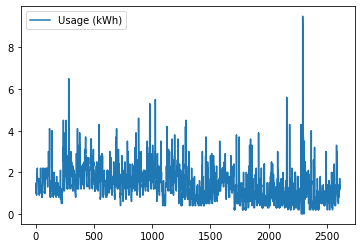

In [6]:
result.plot(y = 'Usage (kWh)')